In [37]:
import pandas as pd 
import numpy as np 
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import warnings

In [38]:
warnings.filterwarnings('ignore')

df = pd.read_csv('../league_dataset_60k.csv')
column_keys = df.keys()
scaler = StandardScaler()

#pop the string label and win output before normalisation
teampos = df.pop("teamPosition")
win = df.pop("win")

df = scaler.fit_transform(df)

df = np.column_stack((teampos, df))
df = pd.DataFrame(np.column_stack((df, win)), columns=column_keys)

grouped = df.groupby(df.teamPosition)
data_top = grouped.get_group("BOTTOM")

## A Peek inside the Datasets

In [39]:
data_bot.head(5)

,teamPosition,12AssistStreakCount,abilityUses,acesBefore15Minutes,alliedJungleMonsterKills,baronTakedowns,blastConeOppositeOpponentCount,bountyGold,buffsStolen,completeSupportQuestInTime,...,trueDamageTaken,turretKills,turretsLost,unrealKills,visionClearedPings,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
3,BOTTOM,0,161,0,8.0,0,0,600,0,0,...,2294,0,7,0,0,24,0,6,6,0
8,BOTTOM,0,221,0,4.0,2,0,1050,0,0,...,2566,4,6,0,0,26,0,5,11,1
13,BOTTOM,0,98,0,6.5,0,0,0,0,0,...,830,1,9,0,0,21,2,2,10,0
18,BOTTOM,0,165,0,4.0,1,0,0,0,0,...,521,1,3,0,0,12,0,1,8,1
23,BOTTOM,0,199,0,0.0,0,0,0,0,0,...,2482,2,11,0,0,22,0,3,12,0


# Feature selection

## Feature importance logistic regression

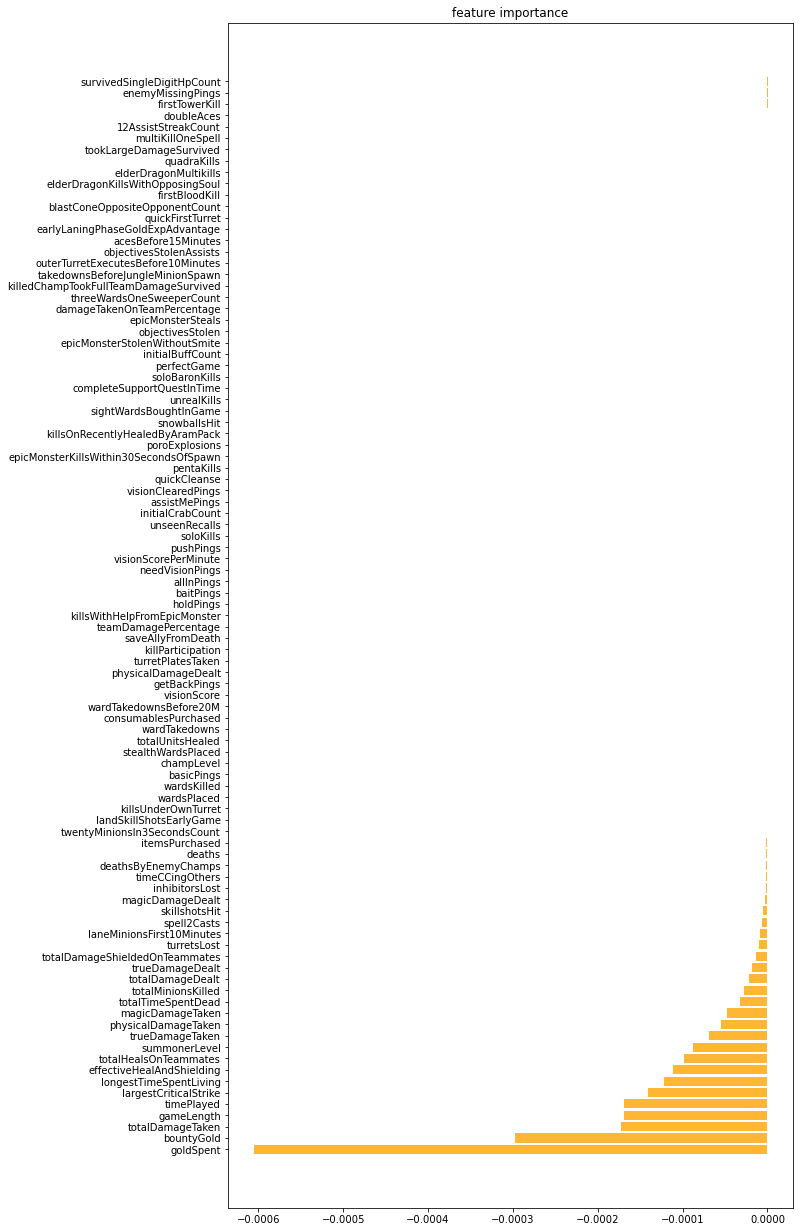

In [40]:
# define dataset
y = data_bot.win.astype('int')
X = data_bot.drop(["teamPosition", "win"], axis=1)
# define the model
model = LogisticRegression(penalty='l2')
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]

feas = pd.DataFrame()
feas['features'] = X.keys()
feas['importance'] = importance
feas = feas.sort_values(by='importance')

feas1 = feas[0:95]
feas2 = feas[95:191]

plot.rc('font', size=10);
fig, axes = plot.subplots(figsize=(11,17))
axes.barh(np.arange(feas1.shape[0]), feas1.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas1.shape[0]))
axes.set_yticklabels(feas1.features.values, rotation='horizontal')

plot.show()

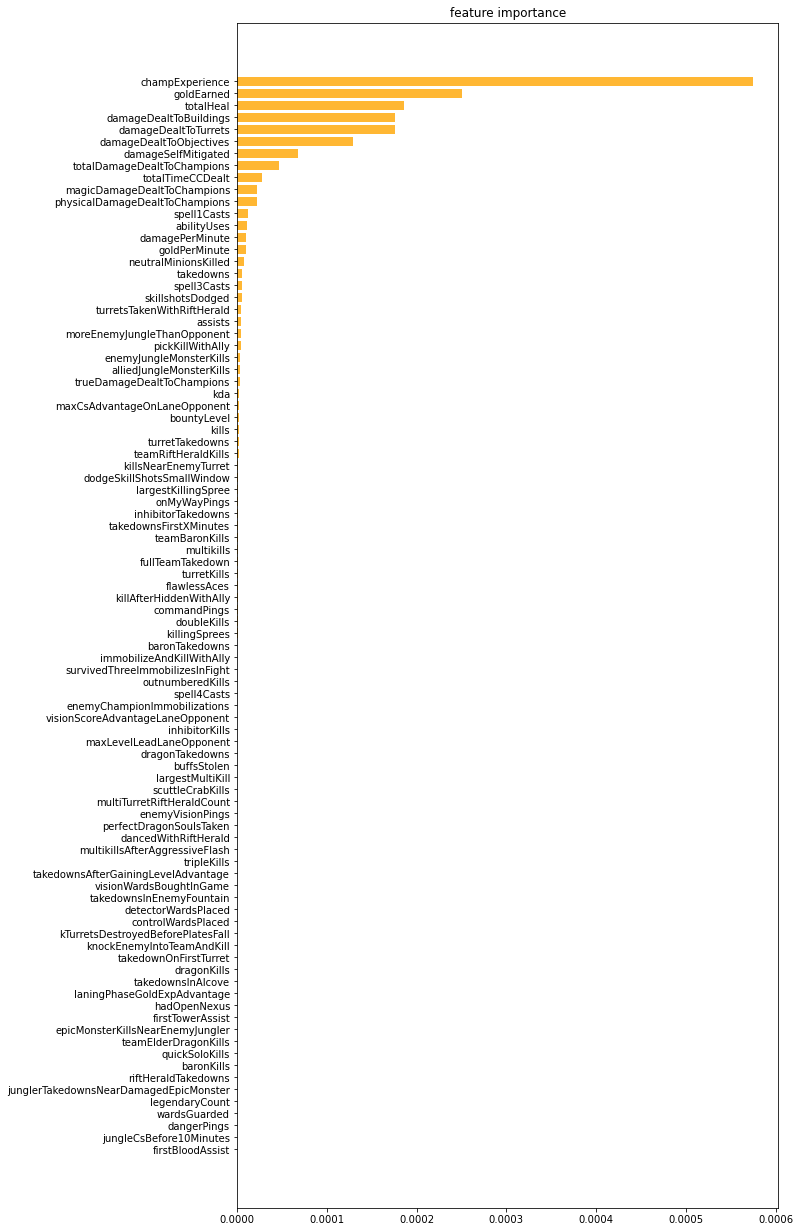

In [41]:
fig, axes = plot.subplots(figsize=(11,17))
axes.barh(np.arange(feas2.shape[0]), feas2.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas2.shape[0]))
axes.set_yticklabels(feas2.features.values, rotation='horizontal')
plot.show()

## Train test split and feature selection

In [42]:
y=data_bot.win.astype('int')
X = data_bot[["goldSpent", "bountyGold","totalDamageTaken","gameLength","timePlayed","goldEarned","longestTimeSpentLiving",
              "effectiveHealAndShielding","damageDealtToTurrets","damageDealtToBuildings","damageDealtToObjectives","largestCriticalStrike"
             ,"damageSelfMitigated","champExperience","totalHeal","totalDamageDealtToChampions"]]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2,stratify=y)

## Baseline model - most common case

In [43]:
dummy = DummyClassifier(strategy='most_frequent').fit(Xtrain, ytrain)
ydummy = dummy.predict(Xtest)
print(confusion_matrix(ytest, ydummy))
print(classification_report(ytest, ydummy))

[[   0 1172]
 [   0 1172]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1172
           1       0.50      1.00      0.67      1172

    accuracy                           0.50      2344
   macro avg       0.25      0.50      0.33      2344
weighted avg       0.25      0.50      0.33      2344



## hyperparameter tuning and cross valiadation - Logistic Classifier(L2)

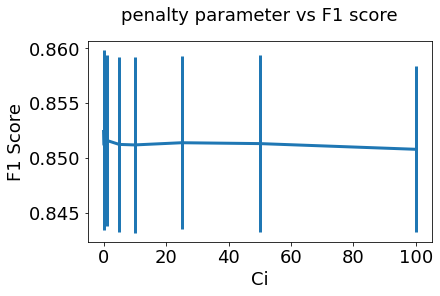

In [49]:
#cross-validation to select the weight C given to the penalty in the cost function.
mean_error=[]
std_error=[]
Ci_range = [0.01, 0.1, 1, 5, 10, 25, 50, 100]
for Ci in Ci_range:
 model = LogisticRegression(C=Ci,penalty='l2');
 scores = cross_val_score(model,Xtrain, ytrain, cv=5, scoring='f1')
 mean_error.append(np.array(scores).mean())
 std_error.append(np.array(scores).std())
plot.rc('font', size=18); plot.rcParams['figure.constrained_layout.use'] = True
plot.errorbar(Ci_range,mean_error,yerr=std_error,linewidth=3)
plot.title("penalty parameter vs F1 score",fontsize=18,pad=20)
plot.xlabel('Ci'); plot.ylabel('F1 Score')
plot.show()

## logistic classifier penalty l2 C=1

In [45]:
lr = LogisticRegression(penalty='l2',C=1,solver='lbfgs')
lr.fit(Xtrain,ytrain)
y_pred = lr.predict(Xtest)
print(confusion_matrix(ytest, y_pred))
print(classification_report(ytest, y_pred))

[[1027  145]
 [ 184  988]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1172
           1       0.87      0.84      0.86      1172

    accuracy                           0.86      2344
   macro avg       0.86      0.86      0.86      2344
weighted avg       0.86      0.86      0.86      2344



## hyperparameter tuning and cross valiadation - Linear SVM

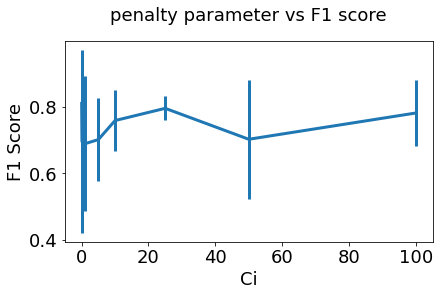

In [52]:
#cross-validation to select the weight C given to the penalty in the cost function.
mean_error=[]
std_error=[]
Ci_range = [0.01, 0.1, 1, 5, 10, 25, 50, 100]
for Ci in Ci_range:
 model = LinearSVC(C=Ci);
 scores = cross_val_score(model,Xtrain, ytrain, cv=5, scoring='f1')
 mean_error.append(np.array(scores).mean())
 std_error.append(np.array(scores).std())
plot.rc('font', size=18); plot.rcParams['figure.constrained_layout.use'] = True
plot.errorbar(Ci_range,mean_error,yerr=std_error,linewidth=3)
plot.title("penalty parameter vs F1 score",fontsize=18,pad=20)
plot.xlabel('Ci'); plot.ylabel('F1 Score')
plot.show()

## Linear SVM C=50

In [54]:
svm = LinearSVC(C=50)
svm.fit(Xtrain,ytrain)
y_pred1 = svm.predict(Xtest)
print(confusion_matrix(ytest, y_pred1))
print(classification_report(ytest, y_pred1))

[[ 937  235]
 [ 112 1060]]
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1172
           1       0.82      0.90      0.86      1172

    accuracy                           0.85      2344
   macro avg       0.86      0.85      0.85      2344
weighted avg       0.86      0.85      0.85      2344



## ROC curve

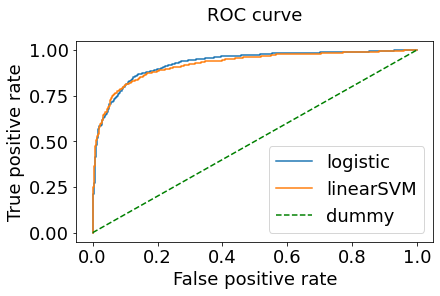

In [51]:
fpr, tpr, _ = roc_curve(ytest,lr.decision_function(Xtest))
plot.plot(fpr,tpr)
fpr1, tpr1, _ = roc_curve(ytest,svm.decision_function(Xtest))
plot.plot(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(ytest,ydummy)
plot.title("ROC curve",fontsize=18,pad=20)
plot.plot(fpr2,tpr2,color='green',linestyle='--')
plot.xlabel('False positive rate')
plot.ylabel('True positive rate')
plot.legend(["logistic","linearSVM", "dummy"]) 
plot.show()